<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 
<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 150px; display: inline"  alt="Wikistat"/></a>
<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" width=400,  style="float:right;  display: inline" alt="IMT"/> </a>
    
</center>

# High Dimensional & Deep Learning : Image classification  on MNIST dataset.

## Objectives
In this TP you will learn to : 
* Write multilayer perceptron and convolutional network with `Keras`and `Tensorflow`
* Understand how `convolutional`, `max pooling`, `stride` and `padding`layers work.
* Use these models for image classification.

## Libraries

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

import pandas as pd
import numpy as np
import time

import tensorflow.keras.utils as ku
import tensorflow.keras.models as km
import tensorflow.keras.layers as kl
import tensorflow.keras.optimizers as ko
import tensorflow.keras.preprocessing.image as k


from sklearn.metrics import confusion_matrix

In [2]:
import tensorflow
tensorflow.__version__

'1.13.1'

This code lines allow you to check if your computer is using CPU or GPU ressources. <br>
**Warning** : You won't be able to use GPU if another notebook is open and still uses GPU.

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7266599512983273275
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9298803460932911284
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10827497472
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2787754253976705491
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1375917814693385525
physical_device_desc: "device: XLA_GPU device"
]


## Dataset 

The dataset that will be used in this TP is the [MNIST DataBase](http://yann.lecun.com/exdb/mnist/).<br>
It is composed of 70.000 images (60.000 for learning, 10.000 for test) of 28x28 pixels of handwritten digits from 0 to 9.<br>

These data are directly available on the `Keras` library.

In [4]:
from tensorflow.keras.datasets import mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
N_train, N_x_pixels, N_y_pixels = X_train.shape
N_test = X_test.shape[0]
N_classes = len(set(Y_train))

print("Train data : %d images  (%d/%d pixels)" %(N_train, N_x_pixels, N_y_pixels))
print("Test data : %d images  (%d/%d pixels)" %(N_test, N_x_pixels, N_y_pixels))

Train data : 60000 images  (28/28 pixels)
Test data : 10000 images  (28/28 pixels)


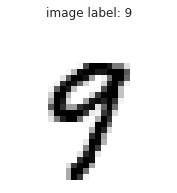

In [5]:
sample_index = 45
fig =plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1,1,1)
ax.imshow(X_train[sample_index], cmap=plt.cm.gray_r, interpolation='nearest')
ax.set_title("image label: %d" % Y_train[sample_index])
ax.grid(False)
ax.axis('off')
plt.show()

### Image example

## Image classification with Multi Layer Perceptron model.

We will first try to learn an image classifier with a MLP model with the following architecture.

* A Dense layer with 128 neurons and *relu* activation function
* A Dropout Layer with 20% drop rate
* A Dense layer with 128 neurons and *relu* activation function
* A Dropout Layer with 20% drop rate
* A Dense layer with 10 neurons (Number of classes ) and *softmax* activation function

### Data format

Some modifications are required on the data to use them with our model. 

The first layer is a Dense Layer, which handles 1D vectors as an input. We must first reshape the 2D 28x28 images as a 1D $28*28=784$ vector.

In [6]:
X_train_flatten = X_train.reshape((N_train, N_x_pixels*N_y_pixels))
X_test_flatten = X_test.reshape((N_test, N_x_pixels*N_y_pixels))
N_dim_flatten = X_train_flatten.shape[1]
print("Dimensions of flatten train images : %d X %d" %(X_train_flatten.shape))
print("Dimensions of flatten test images : %d X %d" %(X_test_flatten.shape))

Dimensions of flatten train images : 60000 X 784
Dimensions of flatten test images : 10000 X 784


### Architecture 

In [7]:
# Définition du réseau
model = km.Sequential()
model.add(kl.Dense(128, # Number of neurons in layer - we specified a dense layer
                   activation='relu', # Specifiying the activation function
                   input_shape=(N_dim_flatten,))) # Dimension of input layer
model.add(kl.Dropout(0.2)) # Dropout (disactivate some neurons with a probability of 20%)
model.add(kl.Dense(128, # Second layer - 128 neurons - Dense layer
                   activation='relu')) # Activation function
model.add(kl.Dropout(0.2)) # Dropout (disactivate some neurons with a probability of 20%)
model.add(kl.Dense(N_classes, # Final layer - as many neurons as classes
                   activation='softmax')) # Softmax (in order to have a probability)
# Réumé
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_______________

**Q** The summary displays the number of pararameters/weigths of the model. Retrieve these values with the formulas seen in the course.

### Training

You will now instantiate your model by defining :
* An optimizer : `RMSprop`
* a loss function : `Categorical crossentropy`
* Metric : This argument is an option, it allows to compute the metric if you want to check the evolution of the training. Here we choose to compute the accuracy during the training.

**Note** : In Keras you can choose either "sparse_categorical_crossentropy" or "categorical_crossentropy" loss. The former handel 1D (NX1) vectors where each entry contains the label of the data, i.e [0,3,5,9,3,4,...]. The latter handle only one-hot encoding of this vector, ie a 2D vectors (NXN_classes) matrices. Keras has a `to_categorical` functions which allows to convert a vector to its one-hot encoding representation.

In [8]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=ko.RMSprop(),
              metrics=['accuracy'])

In [9]:
batch_size = 256
epochs=10
ts = time.time()
history = model.fit(X_train_flatten, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test_flatten, Y_test))
te = time.time()
t_train_mpl = te-ts

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 9s 143us/sample - loss: 5.4360 - acc: 0.6474 - val_loss: 1.9701 - val_acc: 0.8678
Epoch 2/10
60000/60000 [==============================] - 1s 20us/sample - loss: 2.2144 - acc: 0.8517 - val_loss: 1.4299 - val_acc: 0.9034
Epoch 3/10
60000/60000 [==============================] - 1s 22us/sample - loss: 1.7181 - acc: 0.8846 - val_loss: 1.3361 - val_acc: 0.9110
Epoch 4/10
60000/60000 [==============================] - 1s 23us/sample - loss: 1.5559 - acc: 0.8970 - val_loss: 1.1994 - val_acc: 0.9210
Epoch 5/10
60000/60000 [==============================] - 1s 23us/sample - loss: 1.4351 - acc: 0.9056 - val_loss: 1.0814 - val_acc: 0.9295
Epoch 6/10
60000/60000 [==============================] - 1s 23us/sample - loss: 1.3489 - acc: 0.9114 - val_loss: 0.9206 - val_acc: 0.9387
Epoch 7/10
60000/60000 [==============================] - 1s 24us/sample - loss: 1.2541 - acc: 0.9179 - val_loss: 0

In [10]:
t_train_mpl
# First execution takes ~70s
# 2nd execution takes 14s (Since the data has already been loaded to GPU)

73.41832375526428

### Results

Test loss: 0.9143551892682786
Test accuracy: 0.9406
Time Running: 73.42 seconds


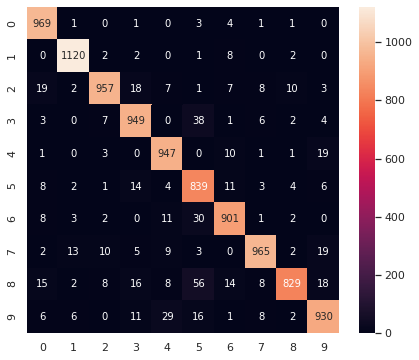

In [11]:
score_mpl = model.evaluate(X_test_flatten, Y_test, verbose=0)
predict_mpl = model.predict(X_test_flatten)
print('Test loss:', score_mpl[0])
print('Test accuracy:', score_mpl[1])
print("Time Running: %.2f seconds" %t_train_mpl )
fig=plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
ax = sb.heatmap(pd.DataFrame(confusion_matrix(Y_test, predict_mpl.argmax(1))), annot=True, fmt="d")


**Question** What can you say about these results?

**Exercise** Normalize the data in order to have values between 0 and 1 and run again the learning. What can you say about these results?

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 23us/sample - loss: 0.7531 - acc: 0.8891 - val_loss: 0.2231 - val_acc: 0.9350
Epoch 2/10
60000/60000 [==============================] - 1s 24us/sample - loss: 0.2226 - acc: 0.9349 - val_loss: 0.1516 - val_acc: 0.9526
Epoch 3/10
60000/60000 [==============================] - 1s 22us/sample - loss: 0.1678 - acc: 0.9503 - val_loss: 0.1236 - val_acc: 0.9614
Epoch 4/10
60000/60000 [==============================] - 2s 25us/sample - loss: 0.1386 - acc: 0.9586 - val_loss: 0.1072 - val_acc: 0.9660
Epoch 5/10
60000/60000 [==============================] - 2s 25us/sample - loss: 0.1197 - acc: 0.9641 - val_loss: 0.0935 - val_acc: 0.9720
Epoch 6/10
60000/60000 [==============================] - 1s 24us/sample - loss: 0.1069 - acc: 0.9681 - val_loss: 0.0901 - val_acc: 0.9727
Epoch 7/10
60000/60000 [==============================] - 1s 25us/sample - loss: 0.0959 - acc: 0.9704 - val_loss: 0.

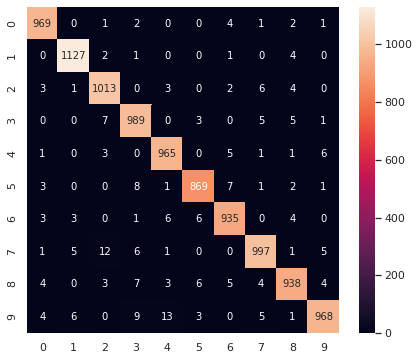

In [12]:
# Retraining the model on normalized dataset

batch_size_norm = 256
epochs_norm=10
ts_norm = time.time()
X_train_flatten_norm = ku.normalize(X_train_flatten)
X_test_flatten_norm = ku.normalize(X_test_flatten)

history_norm = model.fit(X_train_flatten_norm, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test_flatten_norm, Y_test))
te_norm = time.time()
t_train_mpl_norm = te-ts

# Results

score_mpl_norm = model.evaluate(X_test_flatten_norm, Y_test, verbose=0)
predict_mpl_norm = model.predict(X_test_flatten_norm)
print('Test loss:', score_mpl_norm[0])
print('Test accuracy:', score_mpl_norm[1])
print("Time Running: %.2f seconds" %t_train_mpl_norm )
fig=plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
ax = sb.heatmap(pd.DataFrame(confusion_matrix(Y_test, predict_mpl_norm.argmax(1))), annot=True, fmt="d")


## Convolutional Layers

In this part we will use convolution layers to build a convolutional classifier.


#### Data

The convolution architecure takes as input images and no not 1D vectors. However, some data formating are still required.

A third dimension is required : the `channels` dimension which will allow to describe each pixel. In our case this dimension's size is only 1 because the images are only defined with grey scale. However for colour images, each pixel is coded with several values (Images are generally encoded with 3 values (RGB channels)). 

Hence, we need to reshape the images from a 28x28 dimension to a 28X28X1 dimension

In [13]:
X_train_conv = np.expand_dims(X_train,axis=-1)
X_test_conv = np.expand_dims(X_test,axis=-1)
X_train_conv.shape

(60000, 28, 28, 1)

### Edge detection

We will first check the transformation applied by a convolution layer.

In the following code, we define a convolutional network with  only one filter for which we manually define the weights.

In [14]:

conv_filter = np.array([
        [0.2, -0.2, 0],
        [0.2, -0.2, 0],
        [0.2, -0.2, 0],
    ])

def my_init_filter(shape, conv_filter = conv_filter, dtype=None, partition_info=None):
    xf,yf = conv_filter.shape
    array = conv_filter.reshape(xf, yf, 1, 1)
    return array

my_init_filter(0).shape

conv_edge = km.Sequential([
    kl.Conv2D(kernel_size=(3,3), # Size of filter
              filters=1, # Number of filters in layer
              kernel_initializer=my_init_filter, # Filter initializer 
              input_shape=(28, 28, 1)) # Input size
])

 **Q** Note that in  `my_init_filter` two dimensions have been added to the conv filter. What do these dimensions represent?
 
 * The third dimention = number of channels
 * 4th dimention = number of filters
 
 The following code allows to display the image, the filter and the convoluted image.

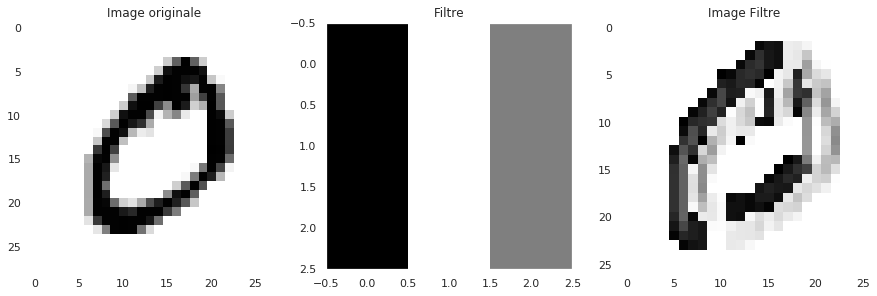

In [33]:
img_in = np.expand_dims(X_train_conv[1], 0)
img_out = conv_edge.predict(img_in)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 5))
ax0.imshow(img_in[0,:,:,0], cmap="binary")
ax0.set_title("Image originale")
ax0.grid(False)

norm_conv_filter = (conv_filter-conv_filter.min())/conv_filter.max()
ax1.imshow(norm_conv_filter.astype(np.uint8), cmap="binary")
ax1.set_title("Filtre")
ax1.grid(False)

ax2.imshow(img_out[0,:,:,0].astype(np.uint8), cmap="binary")
ax2.set_title("Image Filtre")
ax2.grid(False)


**Q** What do you see? Are the output image coherent according to the designed filter ?

**Exercise** Change the code in order to test different filters (to detect horizontal edge, etc...)

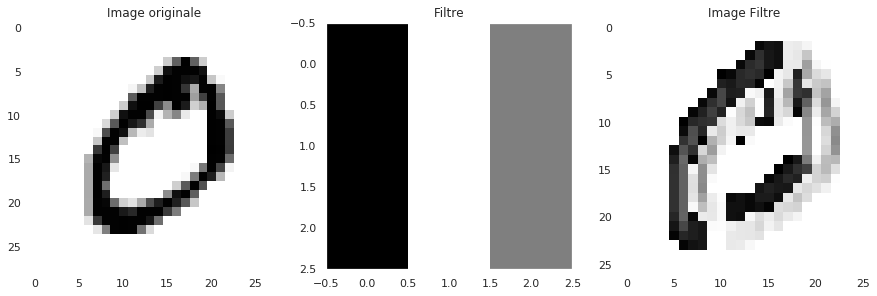

In [15]:

conv_filter_h = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1],
    ])

def my_init_filter_h(shape, conv_filter = conv_filter_h, dtype=None, partition_info=None):
    xf,yf = conv_filter.shape
    array = conv_filter.reshape(xf, yf, 1, 1)
    return array

conv_edge_h = km.Sequential([
    kl.Conv2D(kernel_size=(3,3), # Size of filter
              filters=1, # Number of filters in layer
              kernel_initializer=my_init_filter_h, # Filter initializer 
              input_shape=(28, 28, 1)) # Input size
])

img_in = np.expand_dims(X_train_conv[1], 0)
img_out = conv_edge.predict(img_in)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 5))
ax0.imshow(img_in[0,:,:,0], cmap="binary")
ax0.set_title("Image originale")
ax0.grid(False)

norm_conv_filter = (conv_filter-conv_filter.min())/conv_filter.max()
ax1.imshow(norm_conv_filter.astype(np.uint8), cmap="binary")
ax1.set_title("Filtre")
ax1.grid(False)

ax2.imshow(img_out[0,:,:,0].astype(np.uint8), cmap="binary")
ax2.set_title("Image Filtre")
ax2.grid(False)


### Strides and Padding

We will now study the effect on `strides` and `padding` arguments on the image.


In [16]:
conv_filter = np.array([
        [0, 0, 0],
        [0, 1, 0],
        [0, 0, 0],
    ])

def my_init_filter(shape, conv_filter = conv_filter, dtype=None, partition_info = None):
    xf,yf = conv_filter.shape
    array = conv_filter.reshape(xf, yf, 1, 1)
    return array
my_init_filter(0).shape

conv_sp = km.Sequential([
    kl.Conv2D(kernel_size=(3,3), filters=1, kernel_initializer=my_init_filter, input_shape=(28, 28, 1),
           strides=2, padding="SAME") ])

**Q** What is the effect of the convolutional filter defined here ? 

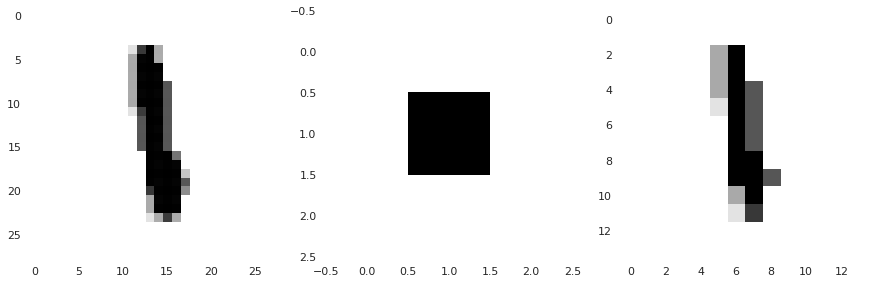

In [22]:
img_in = np.expand_dims(X_train_conv[200], 0)
img_out = conv_sp.predict(img_in)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 5))
ax0.imshow(img_in[0,:,:,0].astype(np.uint8),
           cmap="binary");
ax0.grid(False)

norm_conv_filter = (conv_filter-conv_filter.min())/conv_filter.max()
ax1.imshow(norm_conv_filter.astype(np.uint8),
           cmap="binary");
ax1.grid(False)

ax2.imshow(img_out[0,:,:,0].astype(np.uint8),
           cmap="binary");
ax2.grid(False)

**Exercise** Check the dimension of the output images. Are they coherent? <br>
**Exercise** Change both *stride* and *padding* arguments and understand the effect of these changes.

### Max Pooling

**Exercice** Write a similar code than above to check and understand the behaviour of the `max pooling` layer.

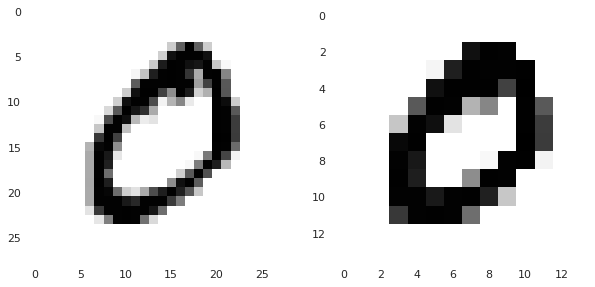

In [25]:
# %load solutions/max_pooling.py
conv_mp = km.Sequential([ kl.MaxPool2D(pool_size=(2,2))])

img_in = np.expand_dims(X_train_conv[1], 0)
img_out = conv_mp.predict(img_in)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0,:,:,0].astype(np.uint8),
           cmap="binary");
ax0.grid(False)

ax1.imshow(img_out[0,:,:,0].astype(np.uint8),
           cmap="binary");
ax1.grid(False)

**Questions** What are the dimension of the output image? Is this normal?

## *Convolutional Network (ConvNet)*

We will now build convolutional networks and see the performances on this kind of model on  image classification problems.

### LeNet5

We first test the  LeNet5 model, proposed by LeCun et al.

In [26]:
LeNet5model = km.Sequential()
LeNet5model.add(kl.Conv2D(filters = 6, kernel_size = 5, strides = 1, activation = 'tanh',
input_shape = (28,28,1)))
LeNet5model.add(kl.MaxPooling2D(pool_size = 2, strides = 2))
LeNet5model.add(kl.Conv2D(filters = 16, kernel_size = 5,strides = 1, activation = 'tanh'))
LeNet5model.add(kl.MaxPooling2D(pool_size = 2, strides = 2))
LeNet5model.add(kl.Flatten())
LeNet5model.add(kl.Dense(units = 120, activation = 'tanh'))
LeNet5model.add(kl.Dense(units = 84, activation = 'tanh'))
LeNet5model.add(kl.Dense(units = 10, activation = 'softmax'))

LeNet5model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               30840     
_________________________________________________________________
dense_4 (Dense)              (None, 84)                10164     
__________

**Exercise** Retrieve 'manually' the number of parameters of this model.

**Question** What can you say about the total number of parameters compared with the MLP model defined before? Which layer has the highest number of parameters?

In [27]:
# Apprentissage
batch_size=128
epochs=30
LeNet5model.compile(loss="sparse_categorical_crossentropy",
              optimizer=ko.Adadelta(),
              metrics=['accuracy'])
ts=time.time()
LeNet5model.fit(X_train_conv, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_conv, Y_test))
te=time.time()
t_train_conv = te-ts

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 4s 68us/sample - loss: 0.2751 - acc: 0.9197 - val_loss: 0.1119 - val_acc: 0.9661
Epoch 2/30
60000/60000 [==============================] - 4s 60us/sample - loss: 0.0963 - acc: 0.9694 - val_loss: 0.0859 - val_acc: 0.9732
Epoch 3/30
60000/60000 [==============================] - 4s 59us/sample - loss: 0.0695 - acc: 0.9776 - val_loss: 0.0654 - val_acc: 0.9787
Epoch 4/30
60000/60000 [==============================] - 4s 63us/sample - loss: 0.0541 - acc: 0.9829 - val_loss: 0.0699 - val_acc: 0.9775
Epoch 5/30
60000/60000 [==============================] - 4s 62us/sample - loss: 0.0443 - acc: 0.9859 - val_loss: 0.0578 - val_acc: 0.9825
Epoch 6/30
60000/60000 [==============================] - 4s 64us/sample - loss: 0.0359 - acc: 0.9889 - val_loss: 0.0520 - val_acc: 0.9838
Epoch 7/30
60000/60000 [==============================] - 4s 64us/sample - loss: 0.0303 - acc: 0.9899 - val_loss: 0.

**Q** Why is the training time longer?

#### Results

Test loss: 0.06363284989105995
Test accuracy: 0.9854
Time Running: 113.44 seconds


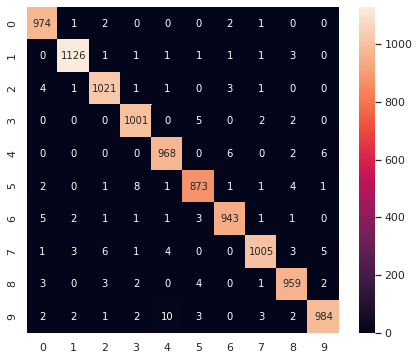

In [28]:
score_conv = LeNet5model.evaluate(X_test_conv, Y_test, verbose=0)
predict_conv = LeNet5model.predict(X_test_conv)
print('Test loss:', score_conv[0])
print('Test accuracy:', score_conv[1])
print("Time Running: %.2f seconds" %t_train_conv )

fig=plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
ax = sb.heatmap(pd.DataFrame(confusion_matrix(Y_test, predict_conv.argmax(1))), annot=True, fmt="d")


### A more complex architecture

#### Network

We will now design a more complex architecture to try to improve the results of the classification :

* A Conv2D layer with 32-3X3 filters and the `Relu` activation function.
* A Conv2D layer with 642-3X3 filters and the `Relu` activation function.
* A MaxPooling layer with a 2X2 window.
* A Dropout layer with a 25% drop rate.
* A flatten layer.
* A Dense layer with 128 neurons  and the `Relu` activation function.
* A Dropout layer with a 50% drop rate.
* A Dense layer with 10 neurons  and the `softmax` activation function.


**Exercise** Define this model and train it.

In [30]:
# %load solutions/mnist_conv_architecture.py
model = km.Sequential()
model.add(kl.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28, 1), data_format="channels_last"))
model.add(kl.Conv2D(64, (3, 3), activation='relu'))
model.add(kl.MaxPooling2D(pool_size=(2, 2)))
model.add(kl.Dropout(0.25))
model.add(kl.Flatten())
model.add(kl.Dense(128, activation='relu'))
model.add(kl.Dropout(0.5))
model.add(kl.Dense(N_classes, activation='softmax'))
# Résumé
model.summary()
# Apprentissage
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=ko.Adadelta(),
              metrics=['accuracy'])
ts=time.time()
model.fit(X_train_conv, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_conv, Y_test))
te=time.time()
t_train_conv = te-ts

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

Test loss: 0.051011668802719574
Test accuracy: 0.9902
Time Running: 121.69 seconds


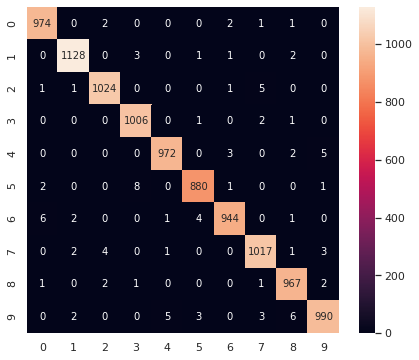

In [33]:
score_conv = model.evaluate(X_test_conv, Y_test, verbose=0)
predict_conv = model.predict(X_test_conv)
print('Test loss:', score_conv[0])
print('Test accuracy:', score_conv[1])
print("Time Running: %.2f seconds" %t_train_conv )

fig=plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
ax = sb.heatmap(pd.DataFrame(confusion_matrix(Y_test, predict_conv.argmax(1))), annot=True, fmt="d")

**Q** Comment the results.

**Q** How to improve them?